#dap-spring-2022

##project topic



---



**Group:** 20Э3

**Author:** Нюкин Дмитрий Сергеевич dsnyukin@edu.hse.ru

**Description:** текстовый анализ и машинное обучение

###  **Задача 1.** Текстовый анализ

Случайным образом были выбраны **5 отраслей экономики**, в каждой отрасли выбиралась компания из фондового индекса **S&P 500** и ближайшая к ней конкурирующая фирма: финансовые услуги – Mastercard (MA) и Visa (V), добыча нефти и газа – Marathon Oil Corporation (MRO) и Devon Energy Corporation (DVN), разработка программного обеспечения –Microsoft (MSFT) и Apple (AAPL), электроника – AMD (AMD) и NVDIA (NVDA), здравоохранение – Universal Health Services (UHS) и Molina Healthcare (MOH). Анализируемый текст – годовая отчётность фирм формы 10-K. Анализируемый период – 6 лет, **2016 – 2021** гг.Попробуем проанализировать её с помощью **финансового** и словаря, используя различные библиотеки python.
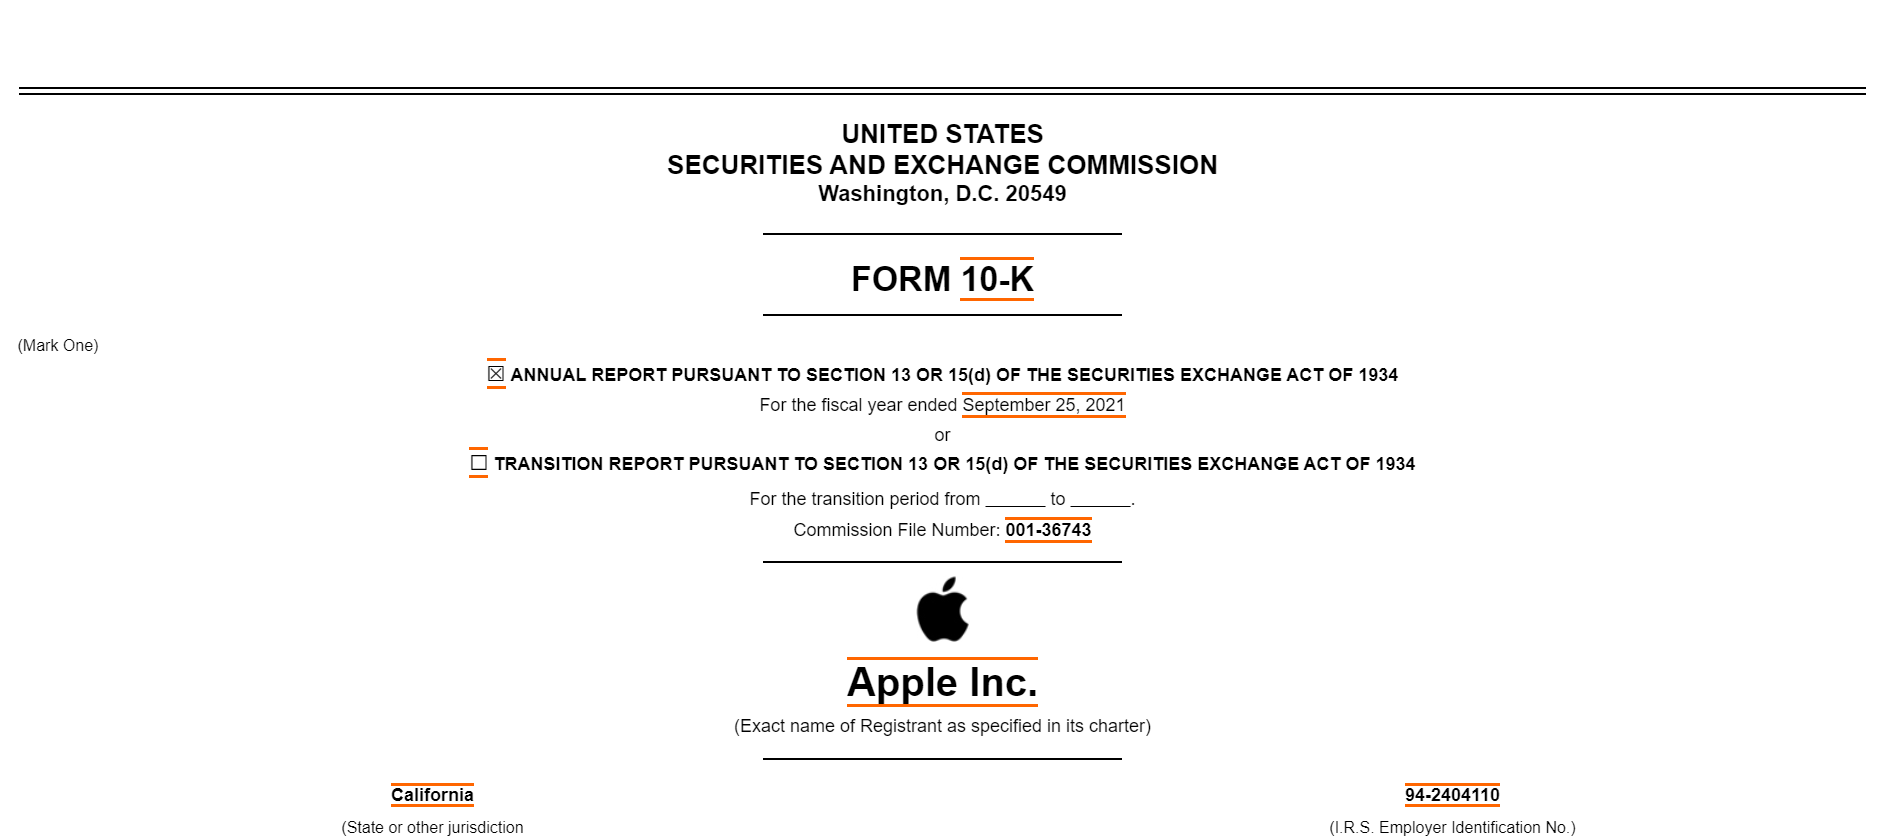



Перед анализом была проведена обработка данных: **удалены изображения**, **таблицы**, документ переделан в текстовый формат **.txt**. Орфография и пунктуация были соблюдены. Обработка скачанных финансовых документов проводилась с использованием пакета Python – **Beautiful Soup 4**. Данная библиотека позволяет извлекать данные из **HTML и HTM** и делает их пригодными для дальнейшего анализа.

In [ ]:
from bs4 import BeautifulSoup as bs
import re

paths = [r'C:\Users\dimal\Desktop\DATA\AMD', r'C:\Users\dimal\Desktop\DATA\APPLE', r'C:\Users\dimal\Desktop\DATA\MarathonOil', r'C:\Users\dimal\Desktop\DATA\MasterCard', r'C:\Users\dimal\Desktop\DATA\UHS']
forms = [r'C:\Users\dimal\Desktop\clean\AMD', r'C:\Users\dimal\Desktop\clean\APPLE', r'C:\Users\dimal\Desktop\clean\MarathonOil', r'C:\Users\dimal\Desktop\clean\MasterCard', r'C:\Users\dimal\Desktop\clean\UHS']
years = [i for i in range(16, 22)]
for i in range(len(paths)):
    for j in range(6):
        with open(paths[i]+'\\'+str(years[j])+'.html', mode='r+') as k:
            k = bs(k).text
            k = re.sub(r"\s+", " ", k)
        with open(forms[i]+'\\'+str(years[j])+'-1'+'.txt', mode='w+', encoding="utf-8") as v:
            v = v.write(k)


После обработки документов - получаем **пригодный для анализа .txt файл**: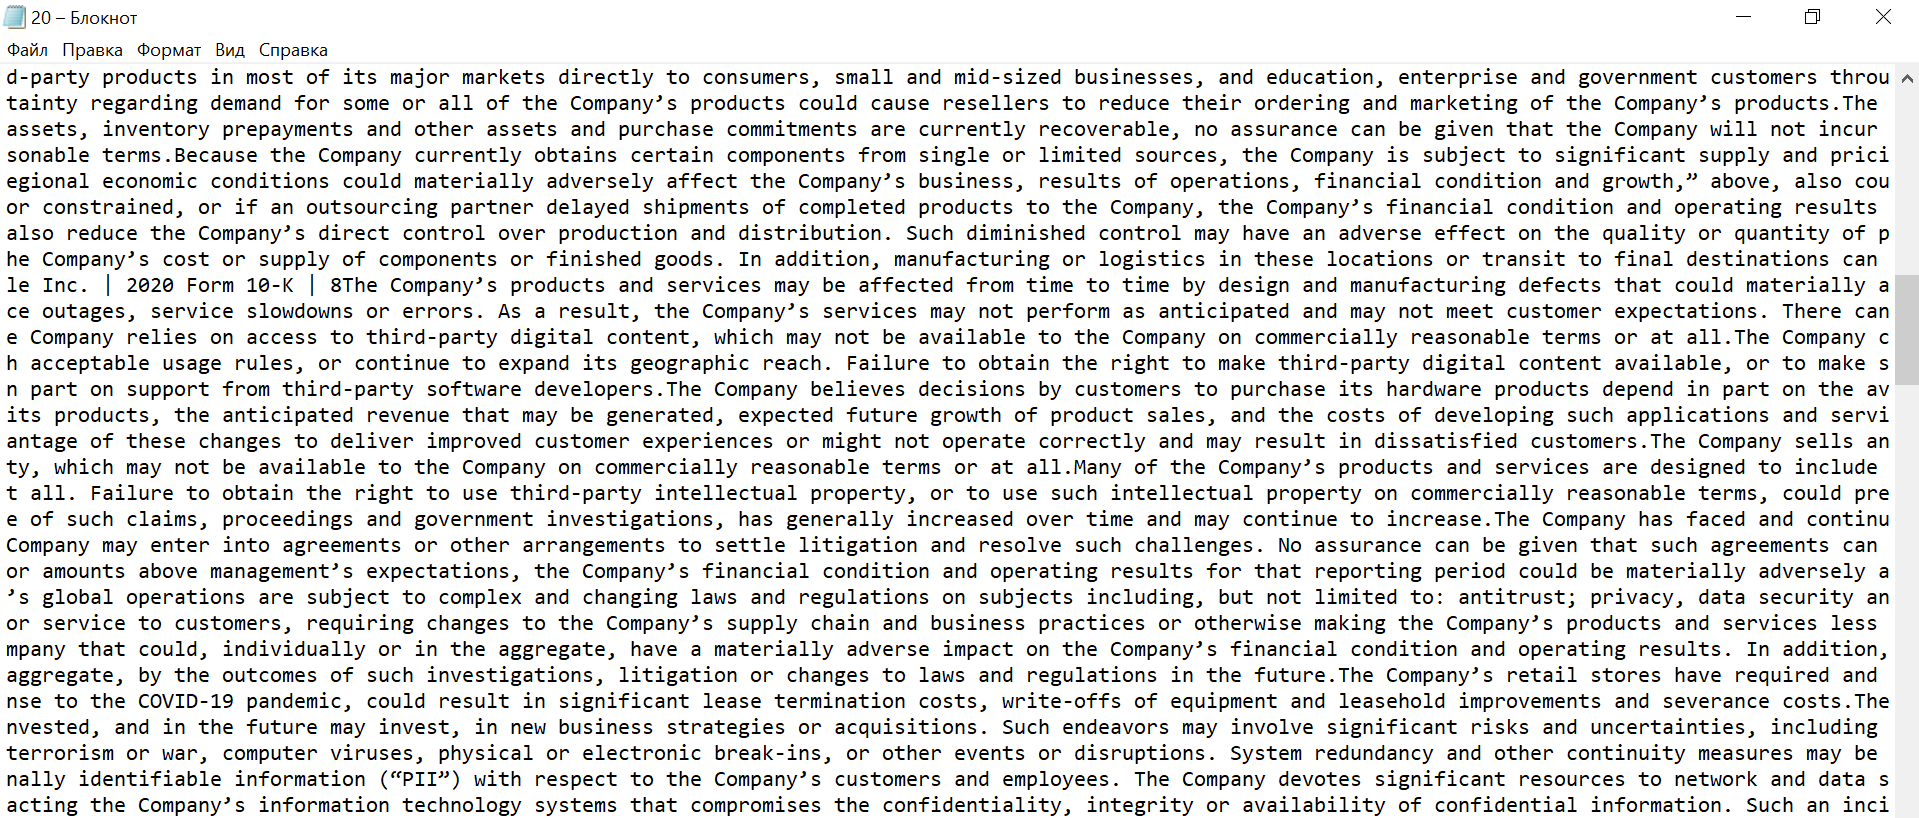


**Основываясь на исследованиях прошлых лет**, для анализа настроения текста была использована программа **Generic Parser**, взятая из репозитория программного обеспечения для бухгалтерского учёта и финансов университета Нотр-Дам. Подсчёт основан на использовании словаря **Loughran-McDonald 2022** года. Так как в используемом словаре слов, отмеченных как “негативные” больше в 6,57 раз, чем слов, отмеченных как “позитивные”, то закономерно, что полученные числа в данной работе будут интерпретироваться как негативная тональность текста. Рассчитывать **тональность текста** было решено как разницу долей негативных и позитивных слов от общего количества соответственно

In [ ]:
import glob
import re
import string
import sys
import time
import csv

# Modify to identify path for custom modules
sys.path.append(r'C:\temp')
import MOD_Load_MasterDictionary_v2022 as LM

# User defined directory for files to be parsed
TARGET_FILES = r'C:\temp\Clean2/*/*'
# User defined file pointer to LM dictionary
MASTER_DICTIONARY_FILE = r'C:\temp' + \
                         '\Loughran-McDonald_MasterDictionary_1993-2021.csv'
# User defined output file
OUTPUT_FILE = r'C:\temp\clresults.csv'
# Setup output
OUTPUT_FIELDS = ['file name,', 'file size,', 'number of words,', '% positive,', '% negative,',
                 '% uncertainty,', '% litigious,', '% modal-weak,', '% modal moderate,',
                 '% modal strong,', '% constraining,', '# of alphabetic,', '# of digits,',
                 '# of numbers,', 'avg # of syllables per word,', 'average word length,', 'vocabulary']

lm_dictionary = LM.load_masterdictionary(MASTER_DICTIONARY_FILE, True)


def main():
    f_out = open(OUTPUT_FILE, 'w')
    wr = csv.writer(f_out, lineterminator='\n')
    wr.writerow(OUTPUT_FIELDS)

    file_list = glob.glob(TARGET_FILES)
    for file in file_list:
        print(file)
        with open(file, 'r', encoding='UTF-8', errors='ignore') as f_in:
            doc = f_in.read()
        doc_len = len(doc)
        doc = re.sub('(May|MAY)', ' ', doc)  # drop all May month references
        doc = doc.upper()  # for this parse caps aren't informative so shift

        output_data = get_data(doc)
        output_data[0] = file
        output_data[1] = doc_len
        wr.writerow(output_data)


def get_data(doc):
    vdictionary = {}
    _odata = [0] * 17
    total_syllables = 0
    word_length = 0

    tokens = re.findall('\w+', doc)  # Note that \w+ splits hyphenated words
    for token in tokens:
        if not token.isdigit() and len(token) > 1 and token in lm_dictionary:
            _odata[2] += 1  # word count
            word_length += len(token)
            if token not in vdictionary:
                vdictionary[token] = 1
            if lm_dictionary[token].positive: _odata[3] += 1
            if lm_dictionary[token].negative: _odata[4] += 1
            if lm_dictionary[token].uncertainty: _odata[5] += 1
            if lm_dictionary[token].litigious: _odata[6] += 1
            if lm_dictionary[token].weak_modal: _odata[7] += 1
            if lm_dictionary[token].strong_modal: _odata[9] += 1
            if lm_dictionary[token].constraining: _odata[10] += 1
            total_syllables += lm_dictionary[token].syllables

    _odata[11] = len(re.findall('[A-Z]', doc))
    _odata[12] = len(re.findall('[0-9]', doc))
    # drop punctuation within numbers for number count
    doc = re.sub('(?!=[0-9])(\.|,)(?=[0-9])', '', doc)
    doc = doc.translate(str.maketrans(string.punctuation, " " * len(string.punctuation)))
    _odata[13] = len(re.findall(r'\b[-+\(]?[$€£]?[-+(]?\d+\)?\b', doc))
    _odata[14] = total_syllables / _odata[2]
    _odata[15] = word_length / _odata[2]
    _odata[16] = len(vdictionary)

    # Convert counts to %
    for i in range(3, 10 + 1):
        _odata[i] = (_odata[i] / _odata[2]) * 100
    # Vocabulary
    return _odata
main()


В итоге - мы получили csv файл, где содержатся различные полезные метрики. Находим тональность текста: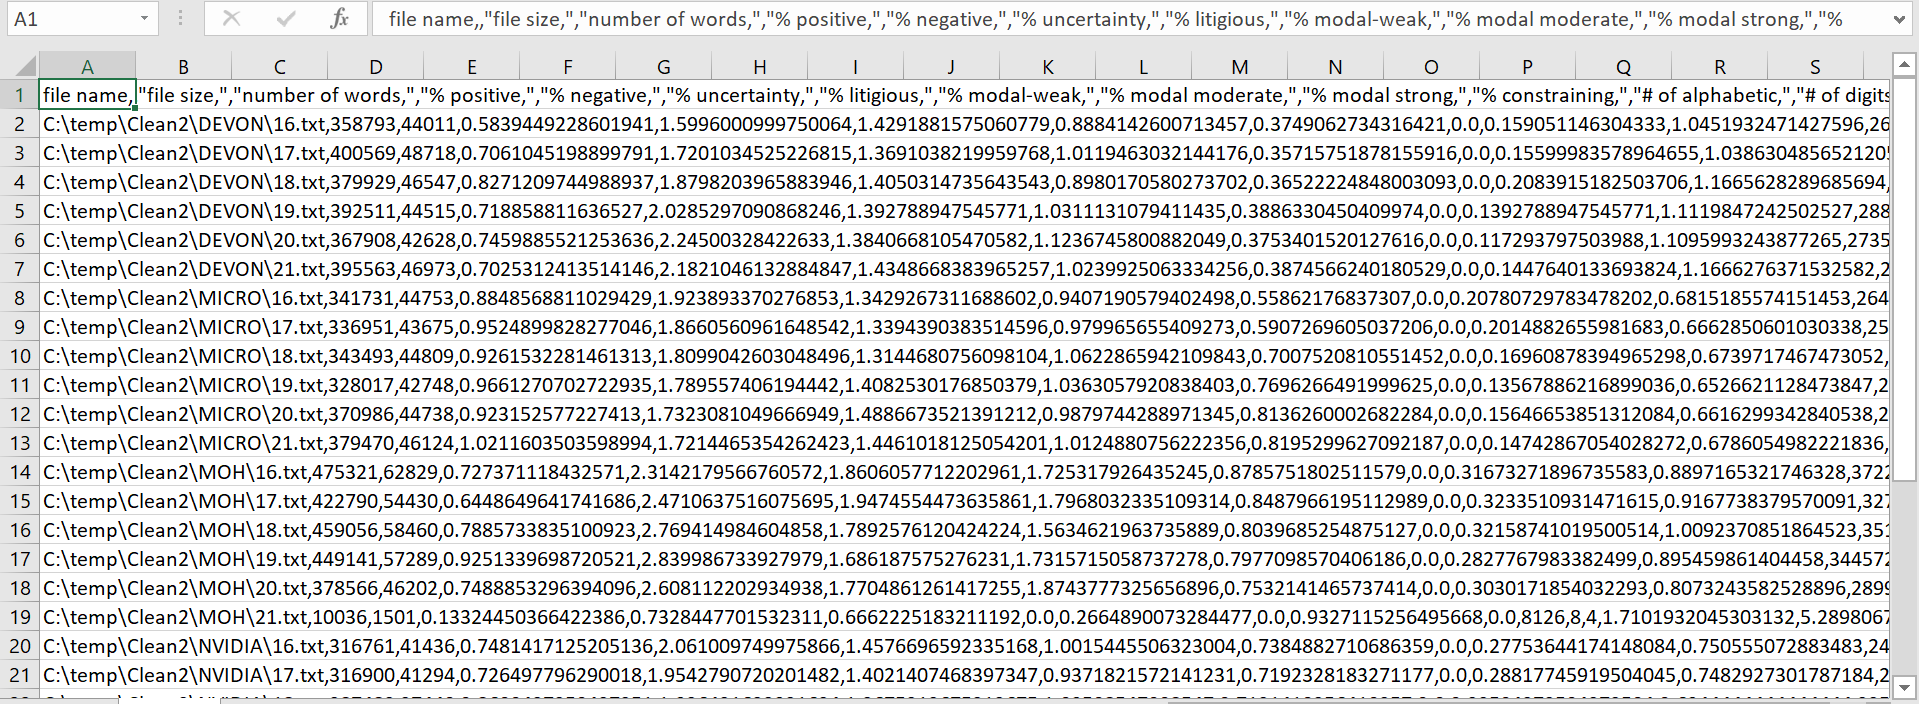

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

In [ ]:
url = "https://raw.githubusercontent.com/DimixL/clresults/main/clresults%20new.csv"

In [ ]:
LMtable = pd.read_csv(url,
                          index_col=0)
LMtable

,AMD,AAPL,MRO,MA,UHS,DVN,MSFT,MOH,NVDA,V
date,,,,,,,,,,
2016,1.64,1.01,1.29,1.38,1.56,1.02,1.04,1.59,1.31,1.38
2017,1.58,1.02,1.21,1.38,1.61,1.02,0.91,1.83,1.23,1.38
2018,1.79,1.13,1.42,1.18,1.63,1.05,0.88,1.98,1.07,1.22
2019,1.90,1.43,1.19,1.10,1.70,1.31,0.82,1.91,1.29,1.26
2020,1.81,1.53,1.19,1.18,1.68,1.50,0.70,1.86,1.28,1.46
2021,1.63,1.68,1.29,1.20,1.34,1.48,0.70,0.60,1.35,1.46


Использование параметров `index_col` функции `read_csv` для определения первого (0-го) столбца в качестве индекса `DataFrame`

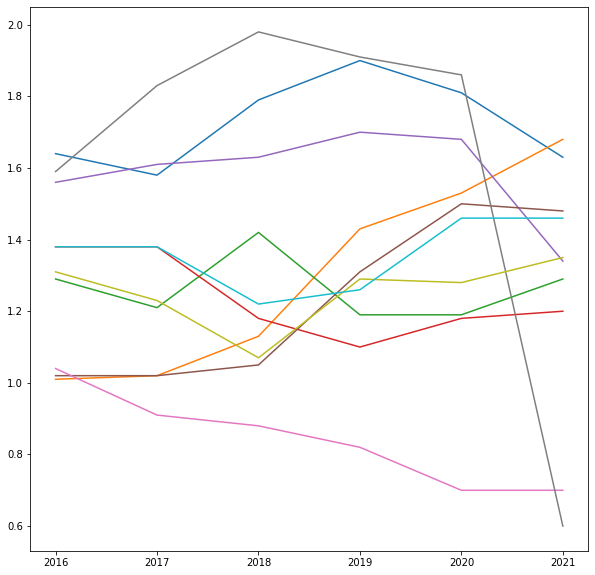

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

plt.plot(LMtable)
plt.show()


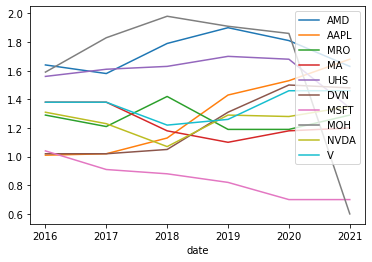

In [ ]:
LMtable.plot()

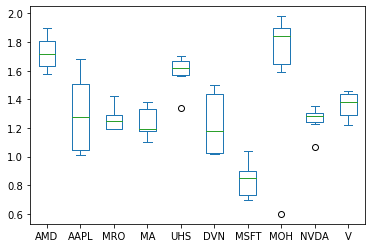

In [ ]:
LMtable.plot.box()

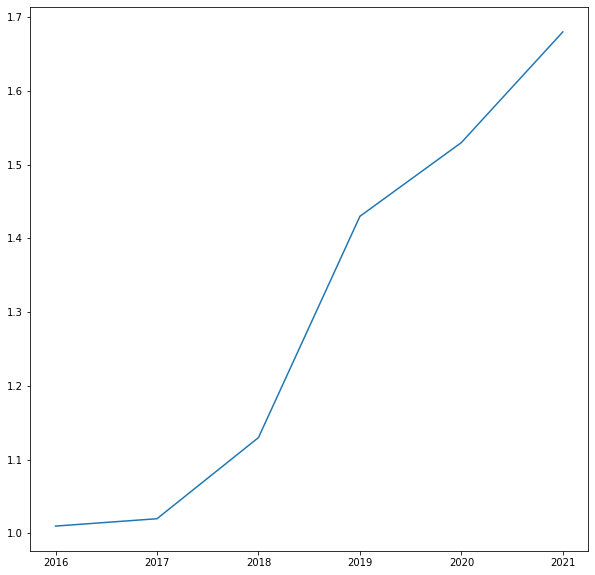

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

plt.plot(LMtable["AAPL"])
plt.show()

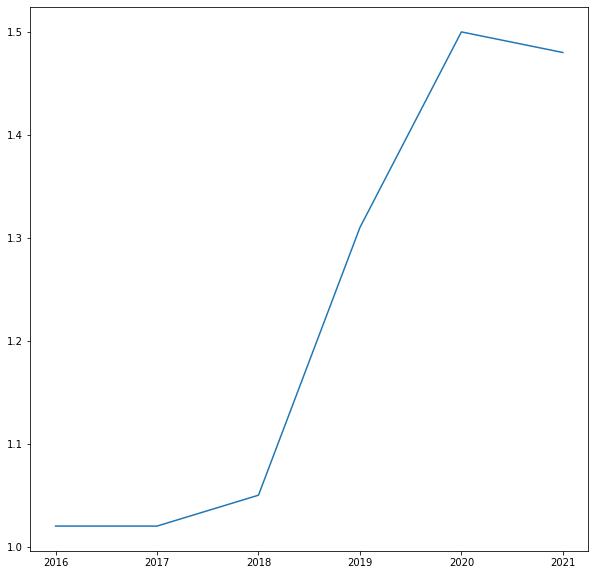

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

plt.plot(LMtable["DVN"])
plt.show()

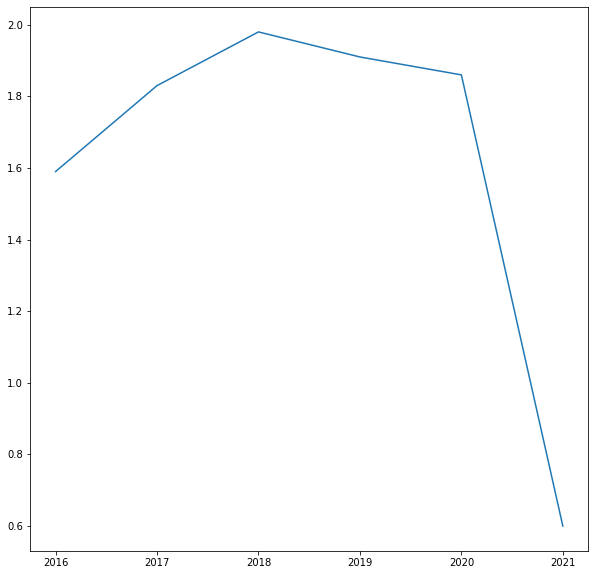

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

plt.plot(LMtable["MOH"])
plt.show()


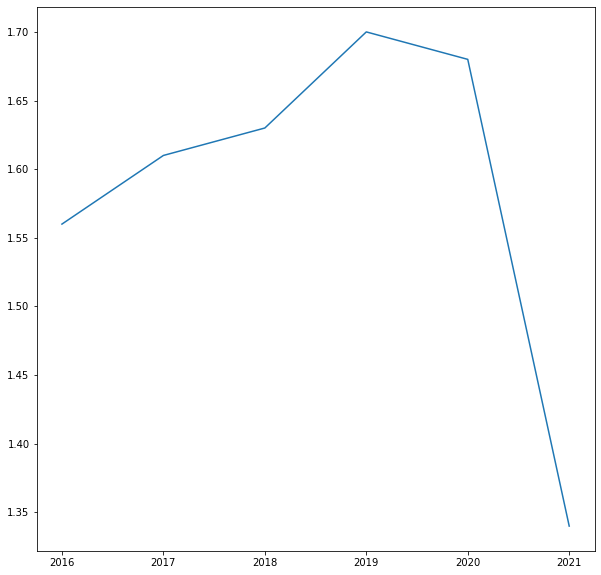

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

plt.plot(LMtable["UHS"])
plt.show()

Заметно **повышение негативной интерпретации** текста к 19-20 гг. Однако, существенное последующее снижение к 21 году заметно только у компаний, относящихся к сфере **здравоохранения** – **Universal Health Services (UHS)** и **Molina Healthcare (MOH)**.

### **Задача 2.** Машинное обучение

**Бэггинг** и случайный лес
В данной задаче мы будем работать с **предсказанием диабета у пациента**. Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
url = 'https://raw.githubusercontent.com/DimixL/clresults/main/diabetes.csv'

In [ ]:
data = pd.read_csv(url)
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

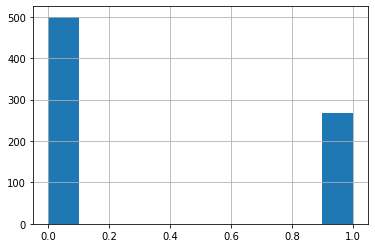

In [ ]:
data['Outcome'].hist()
plt.show()

Выполним действия:
1.   Разделим данные на **признаки** и **целевую переменную**. 
2.   Разделим датасет на **обучающую** и **тестовую** части в отношении 7:3.
3.   Разделим обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3.

(то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
y = data['Outcome']
data.drop('Outcome', axis=1, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42)
X_train_teach, X_train_val, y_train_teach, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

На обучающей-валидационной выборке подберем оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создадим списки с возможными значениями для перебора.
2. Для каждой пары значений обучим дерево на обучающей-обучающей выборке и определим качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберем ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 

**F1-score** - Это комбинация recall и precision: гармоническое среднее. Максимальный F1-score мы получим, если и recall, и precision достаточно далеки от нуля. Он позволяет найти некое компромиссное решение, фактически, между максимизацией TP по разным шкалам.

          
F1 = 2 * (recall * precision) / (recall + precision)
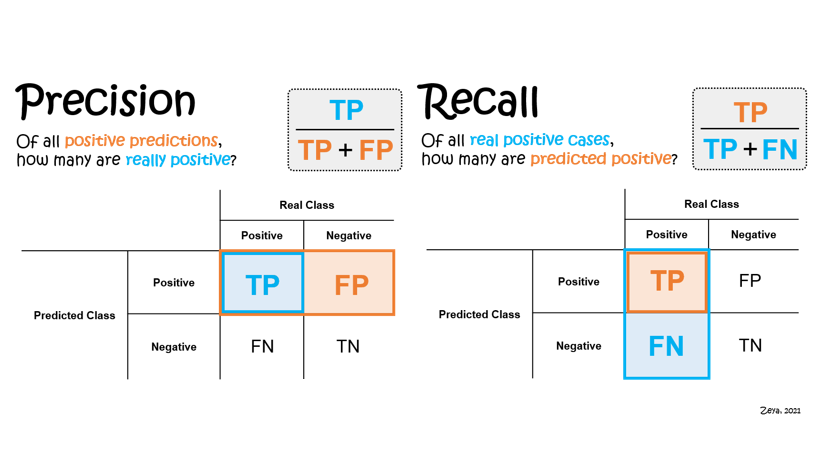

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

max_depth = []
min_samples_leaf = []
f1_scores = []
for i in range(10,100,5):
    for j in range(1,20,1):
        clf = DecisionTreeClassifier(max_depth=i, min_samples_leaf=j, random_state=42)
        clf.fit(X_train_teach,y_train_teach)
        pred = clf.predict(X_train_val)
        max_depth.append(i)
        min_samples_leaf.append(j)
        f1_scores.append(f1_score(y_train_val,pred))

In [ ]:
output = pd.DataFrame({'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf,'f1_score': f1_scores})
output.head()

,max_depth,min_samples_leaf,f1_score
0,10,1,0.621849
1,10,2,0.618182
2,10,3,0.584906
3,10,4,0.590476
4,10,5,0.560748


In [ ]:
df = pd.pivot_table(data=output,
                    index='min_samples_leaf',
                    values='f1_score',
                    columns='max_depth')
df.head()

max_depth,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95
min_samples_leaf,,,,,,,,,,,,,,,,,,
1,0.621849,0.619469,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000
2,0.618182,0.601942,0.609524,0.609524,0.609524,0.609524,0.609524,0.609524,0.609524,0.609524,0.609524,0.609524,0.609524,0.609524,0.609524,0.609524,0.609524,0.609524
3,0.584906,0.566038,0.566038,0.566038,0.566038,0.566038,0.566038,0.566038,0.566038,0.566038,0.566038,0.566038,0.566038,0.566038,0.566038,0.566038,0.566038,0.566038
4,0.590476,0.545455,0.545455,0.545455,0.545455,0.545455,0.545455,0.545455,0.545455,0.545455,0.545455,0.545455,0.545455,0.545455,0.545455,0.545455,0.545455,0.545455
5,0.560748,0.581818,0.581818,0.581818,0.581818,0.581818,0.581818,0.581818,0.581818,0.581818,0.581818,0.581818,0.581818,0.581818,0.581818,0.581818,0.581818,0.581818


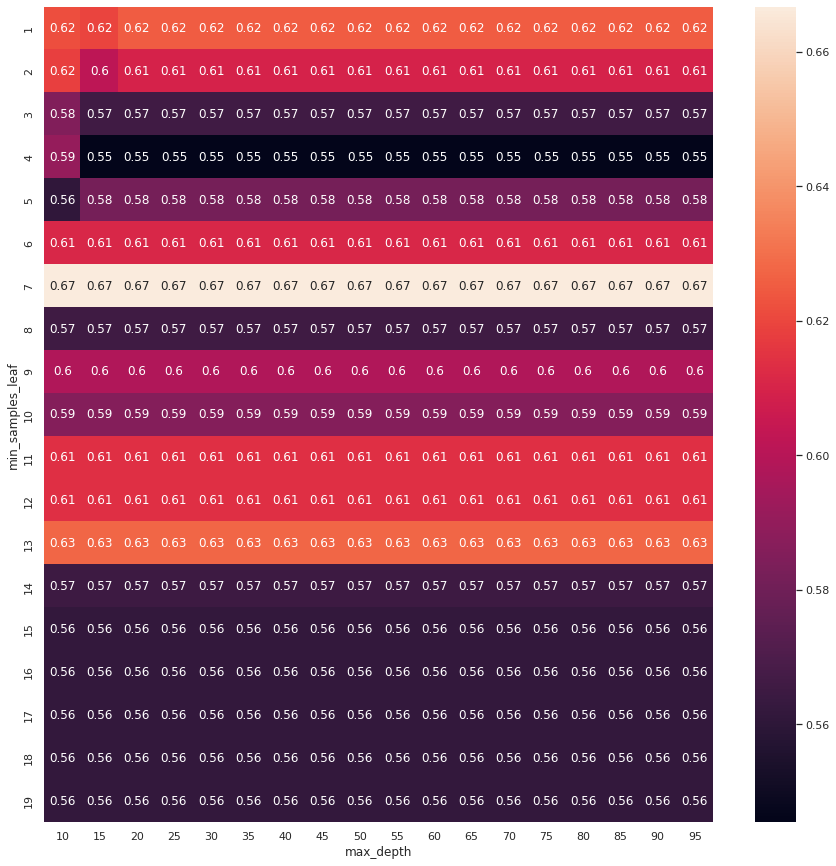

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(df,annot=True)

In [ ]:
clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=7, random_state=42)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=7, random_state=42)

In [ ]:
pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76       151
           1       0.56      0.69      0.62        80

    accuracy                           0.71       231
   macro avg       0.69      0.70      0.69       231
weighted avg       0.73      0.71      0.71       231



Обучим [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оценим качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
clf = BaggingClassifier(n_estimators=50, random_state=42)
clf.fit(X_train,y_train)

BaggingClassifier(n_estimators=50, random_state=42)

In [ ]:
pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       151
           1       0.63      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.72      0.73      0.73       231
weighted avg       0.75      0.75      0.75       231



Выполним **кросс-валидацию** на **полной обучающей** выборке и подберем оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создадим списки с возможными значениями для перебора.
2. Для каждой пары значений проведем кросс-валидацию на полной обучающей выборке. В качестве критерия будем использовать `f1-меру`. Усредним значение критерия по всем прогонам кросс-валидации. 
3. Выберем ту пару значений, которая даёт наилучшее среднее качество. 

Обучим случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оценим качество классификации по тем же метрикам. **Поймем какая из построенных моделей показала себя лучше!!!**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

max_depth = []
min_samples_leaf = []
f1_scores = []
for i in range(10,100,5):
    for j in range(1,20,1):
        clf = RandomForestClassifier(n_estimators=50, max_depth=i, min_samples_leaf=j, random_state=42,n_jobs=-1)
        clf.fit(X_train,y_train)
        pred = clf.predict(X_test)
        max_depth.append(i)
        min_samples_leaf.append(j)
        f1_scores.append(f1_score(y_test,pred))

In [ ]:
import statistics
statistics.mean(f1_scores)

0.6335156477971329

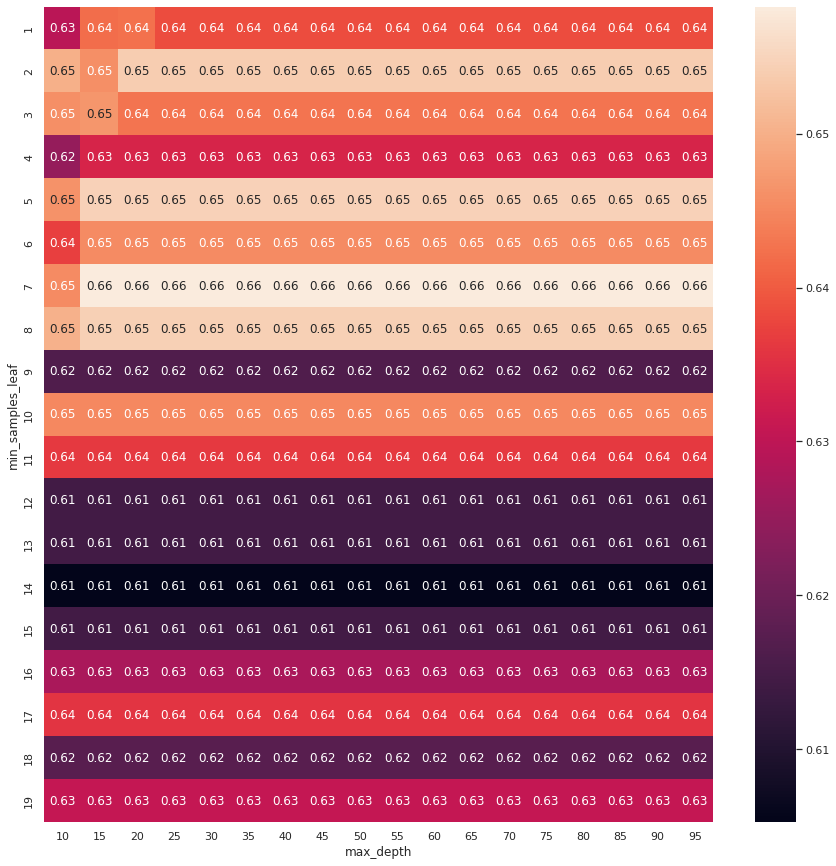

In [ ]:
output = pd.DataFrame({'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf,'f1_score': f1_scores})
df = pd.pivot_table(data=output,
                    index='min_samples_leaf',
                    values='f1_score',
                    columns='max_depth')
import seaborn as sns
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(df,annot=True)

In [ ]:
clf = RandomForestClassifier(n_estimators=50, max_depth=30, min_samples_leaf=7, random_state=42,n_jobs=-1)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       151
           1       0.67      0.65      0.66        80

    accuracy                           0.77       231
   macro avg       0.74      0.74      0.74       231
weighted avg       0.76      0.77      0.77       231



Для лучшей модели случайного леса посчитаем важность признаков и выведем bar plot. **Узнаем самый важный признак для определения диабета!!! - Glucose**

In [ ]:
clf = RandomForestClassifier(n_estimators=50, max_depth=30, min_samples_leaf=7, random_state=42,n_jobs=-1)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)

In [ ]:
clf.feature_importances_

array([0.06640614, 0.35817112, 0.05509329, 0.04183094, 0.06592356,
       0.18288176, 0.07437896, 0.15531424])

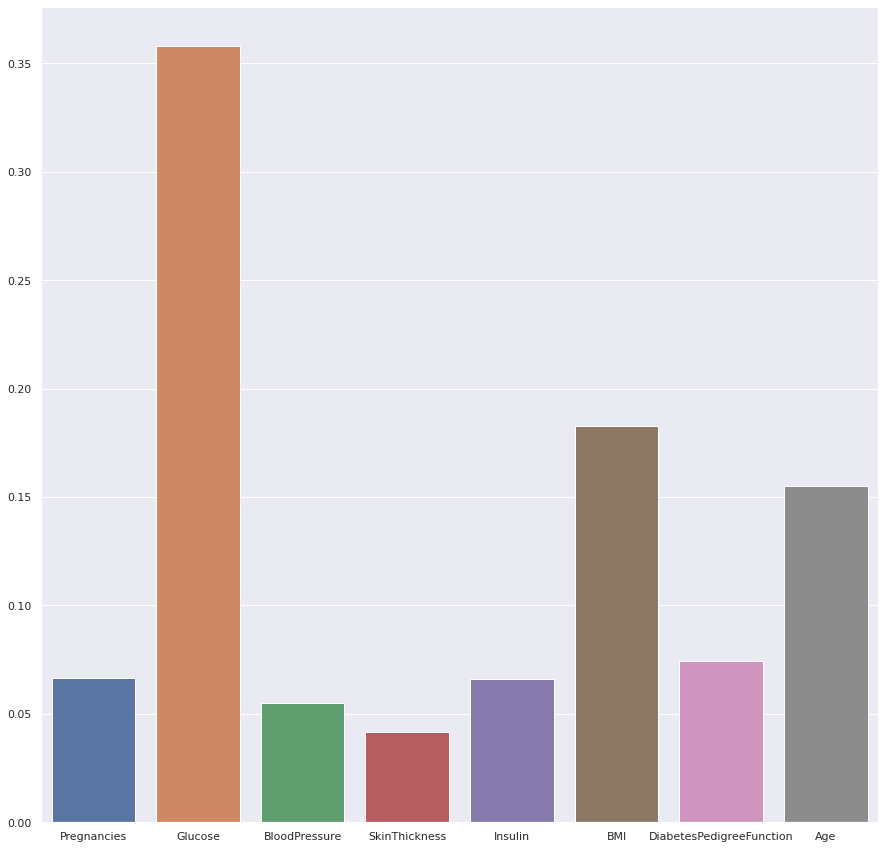

In [ ]:
sns.barplot(x=data.columns,y=clf.feature_importances_)